In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import rksd.metrics as metrics
import rksd.kernels as kernels
import rksd.bootstrap as boot
import rksd.exp_utils as exp_utils
import experiments.kef as exp_kef
import experiments.rbm as exp_rbm

plt.rcParams["mathtext.fontset"] = "cm"

# Load

In [2]:
n = 500
res_stats = pickle.load(open(f"../data/rbm/stats_n{n}_seed2024.pkl", "rb"))

eps_ls = list(res_stats.keys())
eps_ls

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [3]:
# tau = pickle.load(open(f"../data/rbm/tau_n{n}_seed2024.pkl", "rb"))
# tau

In [5]:
# change theta
eps0_ls = [0.05, 0.1, 0.25]
plot_df_ls = {}

for i, eps0 in enumerate(eps0_ls):
    # change theta
    res_stats_new = copy.deepcopy(res_stats)
    for eps in eps_ls:
        tau = jnp.array(res_stats[eps]["tilted_r_boot"]["tau"])
        theta_new = eps0 * tau**0.5
        res_stats_new[eps] = exp_utils.change_theta(res_stats_new[eps], ["tilted_r_boot"], theta_new)
    
    methods = {"standard": "IMQ-KSD", "tilted": "Tilted-KSD", "tilted_r_boot": "R-KSD"}
    
    plot_df = {"eps": [], "nonsq_stat": [], "method": [], "rej": []}
    for eps in eps_ls:
        for m, m_label in methods.items():
            rr = res_stats_new[eps][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
    
    plot_df = pd.DataFrame(plot_df)
    plot_df_ls[eps0] = plot_df

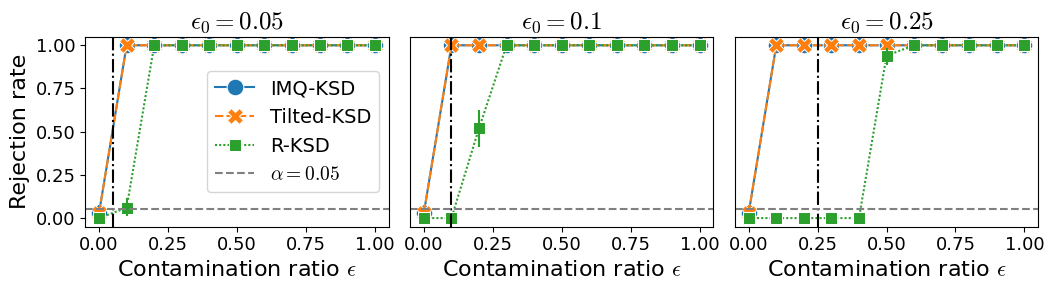

In [8]:
_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(3.5*len(eps0_ls), 3))

for i, eps0 in enumerate(eps0_ls):
    plot_df = plot_df_ls[eps0]

    ax = axes[i]
    _ = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
    ax.axvline(eps0, color="k", linestyle="-.")
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    ax.set_xlabel(r"Contamination ratio $\epsilon$", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.tick_params(axis="both", labelsize=13)
    ax.set_title(rf"$\epsilon_0={eps0}$", fontsize=18)
    if i > 0:
        ax.legend([],[], frameon=False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

# lgd = axes[0].legend(bbox_to_anchor=(0.65, 1.11, 1, 0.2), loc="lower left", ncol=6, fontsize=12)
# plt.subplots_adjust(wspace=0.1)
# plt.savefig("../figs/robust/rbm.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

axes[0].legend(fontsize=14, loc="center right")
plt.tight_layout()
plt.savefig("../figs/robust/rbm.pdf")

# Samples

In [9]:
import rksd.kgof_density as kgof_den

In [10]:
X_res = pickle.load(open(f"../data/rbm/X_res_n{n}_seed2024.pkl", "rb"))
score_res = pickle.load(open(f"../data/rbm/score_res_n{n}_seed2024.pkl", "rb"))
ol_res = pickle.load(open(f"../data/rbm/ol_res_n{n}_seed2024.pkl", "rb"))

In [11]:
key = jax.random.key(2024)
keys = jax.random.split(key, 4)

dim = 50
hdim = 10

b = jax.random.normal(keys[0], shape=(dim,))
c = jax.random.normal(keys[1], shape=(hdim,))
B = jax.random.bernoulli(keys[2], shape=(dim, hdim)).astype(jnp.float32) * 2 - 1.

rbm_model = kgof_den.GaussBernRBM(B, b, c)

In [12]:
eps = 0.1
X = X_res[eps][0]
ol = ol_res[eps][0]
ol_pad = np.copy(ol)

# cmopute med
med = np.median(X, axis=0)

# pad with median
ol_pad[:, 2:] = med[2:]

# compute density
plot_lims = [-7, 10]

x_grid = np.linspace(plot_lims[0], plot_lims[1], 1001)
    
lp = np.empty((x_grid.shape[0], x_grid.shape[0]))
for j, x1 in tqdm(enumerate(x_grid), total=x_grid.shape[0]):
    X_pad = np.empty((x_grid.shape[0], dim))
    X_pad[:, 0] = x1
    X_pad[:, 1] = x_grid
    X_pad[:, 2:] = 0. # med[2:]
    
    lp_X = rbm_model.log_den(X_pad)
    lp[j] = lp_X

  0%|          | 0/1001 [00:00<?, ?it/s]

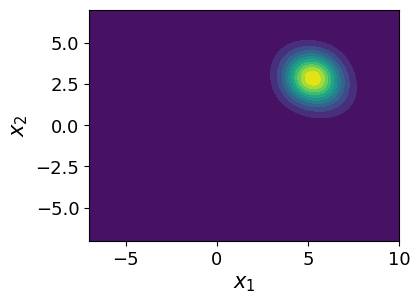

In [45]:
_, ax = plt.subplots(figsize=(4, 3))

xlims = [[-7, 10]]
ylims = [[-7, 7]]

y_plot, x_plot = np.meshgrid(x_grid, x_grid)
ax.contourf(x_plot, y_plot, np.exp(lp), levels=10)
# ax.scatter(X[:, 0], X[:, 1], color="grey", label="Data")
# ax.scatter(ol_pad[:, 0], ol_pad[:, 1], color="C1", label="Outliers")

ax.set_xlim(xlims[i])
ax.set_ylim(ylims[i])
ax.set_xlabel(r"$x_1$", fontsize=15)
ax.set_ylabel(r"$x_2$", fontsize=15)
ax.tick_params(axis="both", labelsize=13)


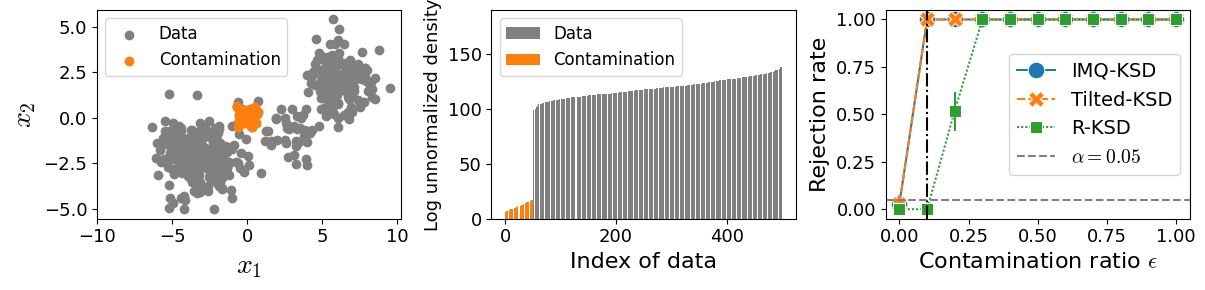

In [61]:
# _, axes = plt.subplots(ncols=2, figsize=(4*2, 3))

# eps = 0.1
# for i, ax in enumerate(axes):
#     X = X_res[eps][0]
#     ol = ol_res[eps][0]
    
#     ax.scatter(X[:, i*2], X[:, i*2+1], color="grey", label="Data")
#     ax.scatter(ol[:, i*2], ol[:, i*2+1], color="C1", label="Outliers")
#     ax.set_xlabel(rf"$x_{i*2+1}$", fontsize=20)
#     ax.set_ylabel(rf"$x_{i*2+2}$", fontsize=20)
#     ax.tick_params(axis="both", labelsize=14)

# lgd = ax.legend(fontsize=14, bbox_to_anchor=(1., 0.5, 1, 0.2), loc="lower left")
# plt.tight_layout()
# # plt.savefig("../figs/robust/rbm_data.pdf", bbox_extra_artists=(lgd,))


_, axes = plt.subplots(ncols=3, figsize=(4*3, 3))

eps = 0.1
X = X_res[eps][0]
ol = ol_res[eps][0]
lp = lp

lp_X = rbm_model.log_den(X)
idx_ordered = np.argsort(lp_X)
lp_ol = rbm_model.log_den(ol)
idx_ordered_ol = np.argsort(lp_ol)

# 1. data
ax = axes[0]
ax.scatter(X[:, 0], X[:, 1], color="grey", label="Data")
ax.scatter(ol[:, 0], ol[:, 1], color="C1", label="Contamination")
ax.set_xlabel(rf"$x_1$", fontsize=20)
ax.set_ylabel(rf"$x_2$", fontsize=20)
ax.tick_params(axis="both", labelsize=13)
ax.set_xlim(-10)
lgd = ax.legend(fontsize=12, loc="upper left")

# 2. log den
ax = axes[1]
ax.bar(range(X.shape[0]), lp_X[idx_ordered], color="grey", label="Data")
ax.bar(range(ol.shape[0]), lp_ol[idx_ordered_ol], color="C1", label="Contamination")
ax.set_xlabel("Index of data", fontsize=16)
ax.set_ylabel("Log unnormalized density", fontsize=13)
ax.tick_params(axis="both", labelsize=13)
ax.set_ylim(0., 190)
lgd = ax.legend(fontsize=12, loc="upper left")

# 3. rej prob
eps0 = 0.1
plot_df = plot_df_ls[eps0]

ax = axes[2]
_ = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
ax.axvline(eps0, color="k", linestyle="-.")
ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.set_xlabel(r"Contamination ratio $\epsilon$", fontsize=16)
ax.set_ylabel("Rejection rate", fontsize=16)
ax.tick_params(axis="both", labelsize=13)
# ax.set_title(rf"$\epsilon_0={eps0}$", fontsize=18)
ax.legend(fontsize=14, loc="center right")

plt.tight_layout()
plt.savefig("../figs/robust/rbm.pdf", bbox_extra_artists=(lgd,))

In [28]:
ol.shape[0] / X.shape[0]

0.1

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

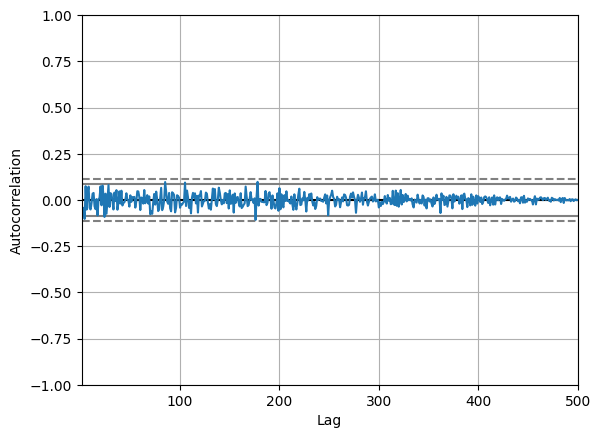

In [4]:
# pd.plotting.autocorrelation_plot(X[:, 0])

# Sampling cost

In [56]:
time_sample = pickle.load(open(f"../data/rbm/time_sample_n{n}_seed2024.pkl", "rb"))
time_test = np.array(res_stats[eps_ls[0]]["tilted_r_boot"]["time"])

In [57]:
time_x_mean = np.mean(time_sample)
time_test_mean = np.mean(time_test)

In [58]:
print(f"Time taken to sample {n} data: mean: {time_x_mean}; std: {time_sample.std()}")
print(f"Time taken to compute ksd: mean: {time_test_mean}; std: {time_test.std()}")

Time taken to sample 500 data: mean: 58.396837899684904; std: 1.5189160566380109
Time taken to compute ksd: mean: 0.8442607808113098; std: 0.0603571663554418
